In [1]:
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy
import random
import gym
import scipy
import pickle
from SpiderEnv.SpiderEnv import SpiderEnv

# Common functions

In [2]:
# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))

In [3]:
def make_env(env_id, seed):
    def _f():
        env = SpiderEnv()
        env.seed(seed)
        return env
    return _f

# Some theory

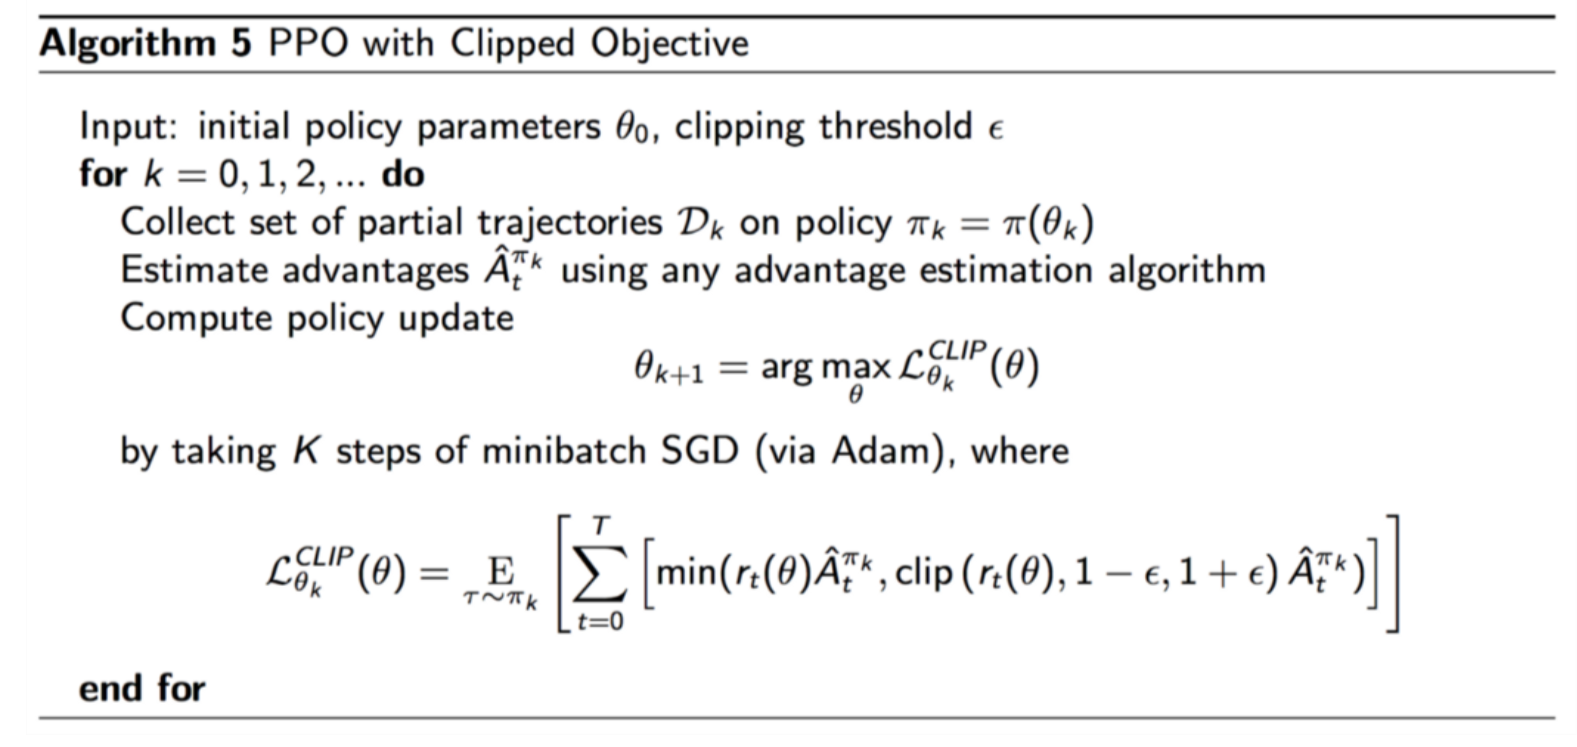

##  Probability ratio

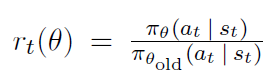

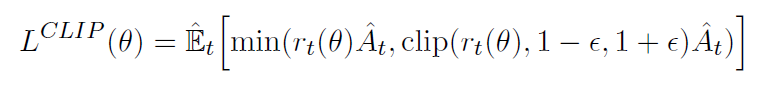

## Generalized Advantage Estimator (GAE): 

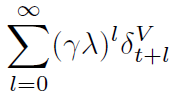

# Global variables

In [4]:
env_name = "SpiderEnv"
pi_learning_rate = 1e-4
v_learning_rate = 1e-3
discount_factor = 0.98
lambda_factor = 0.96

epochs = 10000
steps_per_epoch = 50

batch_size = 512
history_size = batch_size

nproc = 30
envs = DummyVecEnv([make_env(env_name, seed) for seed in range(nproc)]) #Dummy
        
# This code gets action and observation space sizes for 1D tasks
action_space_size = envs.action_space.n if isinstance(envs.action_space, gym.spaces.discrete.Discrete) else envs.action_space.shape[0]
observation_space_size = envs.observation_space.n if isinstance(envs.observation_space, gym.spaces.discrete.Discrete) else envs.observation_space.shape[0]

clip_ratio = 0.2
target_kl = 0.01

In [5]:
logger = {
    "actor_loss": [],
    "actor_gradients_max_abs": [],
    "actor_gradients_equal_zero": [],
    "approx_kl": [],
    "approx_ent": [],
    "clipfrac": [],
    "critic_loss": [],
    "critic_gradients_max_abs": [],
    "critic_gradients_equal_zero": [],
    "value_mean": [],
    "reward": [],
    "critic_accuracy": [],
    "adv_mean": [],
}

## Neural net configuration 

In [6]:
tf.reset_default_graph()
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)


In [7]:
EPS = 1e-8
def gaussian_likelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x-mu)/(tf.exp(log_std)+EPS))**2 + 2*log_std + np.log(2*np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

## Actor 

In [8]:
class DiscreteActorNetwork():
    def __init__(self):
        var_scope_name = "discrete_actor/"
        with tf.variable_scope(var_scope_name):
            self.input_state = tf.placeholder(tf.float32, shape=(None, observation_space_size), name="input_state")
            self.hidden1 = tf.layers.dense(self.input_state, units=100, activation=tf.tanh)
            self.hidden2 = tf.layers.dense(self.hidden1, units=50, activation=tf.tanh)
            self.hidden3 = tf.layers.dense(self.hidden2, units=25, activation=tf.tanh)
            self.output_layer = tf.layers.dense(self.hidden3, units=action_space_size)

            self.action_ph = tf.placeholder(tf.int32, shape=(None), name="action_ph")
            self.adv_ph = tf.placeholder(tf.float32, shape=(None), name="adv_ph")
            self.logp_old_ph = tf.placeholder(tf.float32, shape=(None), name="log_old_ph")
            
            self.action_mask = tf.one_hot(self.action_ph, action_space_size)

            self.action_op = tf.squeeze(tf.multinomial(logits=self.output_layer, num_samples=1), axis=1)
            action_mask_pi = tf.one_hot(self.action_op, action_space_size)
            self.logp_pi = tf.reduce_sum(action_mask_pi * tf.nn.log_softmax(self.output_layer), axis=1)
            
            self.logp = tf.reduce_sum(self.action_mask * tf.nn.log_softmax(self.output_layer), axis=1)
            
            self.ratio = tf.exp(self.logp - self.logp_old_ph)
            self.min_adv = tf.where(self.adv_ph > 0, (1 + clip_ratio) * self.adv_ph, (1 - clip_ratio) * self.adv_ph)
            self.loss = -tf.reduce_mean(tf.minimum(self.ratio * self.adv_ph, self.min_adv))

            self.train_op = tf.train.AdamOptimizer(pi_learning_rate).minimize(self.loss)
            
            # Info (useful to watch during learning)
            self.gradients = tf.gradients(self.loss, [t_var for t_var in tf.trainable_variables() if var_scope_name in t_var.name]) # For Debug!
            self.approx_kl = tf.reduce_mean(self.logp_old_ph - self.logp)      # a sample estimate for KL-divergence, easy to compute
            self.approx_ent = tf.reduce_mean(-self.logp)                  # a sample estimate for entropy, also easy to compute
            self.clipped = tf.logical_or(self.ratio > (1+clip_ratio), self.ratio < (1-clip_ratio))
            self.clipfrac = tf.reduce_mean(tf.cast(self.clipped, tf.float32))

In [9]:
class ActorNetwork():
    def __init__(self):
        var_scope_name = "actor/"
        with tf.variable_scope(var_scope_name):
            self.input_state = tf.placeholder(tf.float32, shape=(None, observation_space_size), name="input_state")
            self.hidden1 = tf.layers.dense(self.input_state, units=100, activation=tf.tanh)
            self.hidden2 = tf.layers.dense(self.hidden1, units=50, activation=tf.tanh)
            self.hidden3 = tf.layers.dense(self.hidden2, units=25, activation=tf.tanh)
            self.output_layer = tf.layers.dense(self.hidden3, units=action_space_size)

            self.action_ph = tf.placeholder(tf.float32, shape=(None, action_space_size), name="action_ph")
            self.adv_ph = tf.placeholder(tf.float32, shape=(None), name="adv_ph")
            self.logp_old_ph = tf.placeholder(tf.float32, shape=(None), name="logp_old_ph")
            
            log_std = tf.get_variable(name='log_std', initializer=-0.5*np.ones(action_space_size, dtype=np.float32))
            std = tf.exp(log_std)
            self.logp = gaussian_likelihood(self.action_ph, self.output_layer, log_std)

            self.action_op = self.output_layer + tf.random_normal(tf.shape(self.output_layer)) * std
            self.logp_pi = gaussian_likelihood(self.action_op, self.output_layer, log_std)
            
            self.ratio = tf.exp(self.logp - self.logp_old_ph)
            self.min_adv = tf.where(self.adv_ph > 0, (1 + clip_ratio) * self.adv_ph, (1 - clip_ratio) * self.adv_ph)
            self.loss = -tf.reduce_mean(tf.minimum(self.ratio * self.adv_ph, self.min_adv))
            
            self.gradients = tf.gradients(self.loss, [t_var for t_var in tf.trainable_variables() if var_scope_name in t_var.name]) # For Debug!
            self.train_op = tf.train.AdamOptimizer(pi_learning_rate).minimize(self.loss)
            
            # Info (useful to watch during learning)
            self.gradients = tf.gradients(self.loss, [t_var for t_var in tf.trainable_variables() if var_scope_name in t_var.name]) # For Debug!
            self.approx_kl = tf.reduce_mean(self.logp_old_ph - self.logp)      # a sample estimate for KL-divergence, easy to compute
            self.approx_ent = tf.reduce_mean(-self.logp)                  # a sample estimate for entropy, also easy to compute
            self.clipped = tf.logical_or(self.ratio > (1+clip_ratio), self.ratio < (1-clip_ratio))
            self.clipfrac = tf.reduce_mean(tf.cast(self.clipped, tf.float32))

## Critic 

In [10]:
class CriticNetwork():
    def __init__(self):
        var_scope_name = "critic/"
        with tf.variable_scope(var_scope_name):
            self.input_state = tf.placeholder(tf.float32, shape=(None, observation_space_size))
            self.hidden1 = tf.layers.dense(self.input_state, units=100, activation=tf.nn.tanh)
            self.hidden2 = tf.layers.dense(self.hidden1, units=50, activation=tf.nn.tanh)
            self.hidden3 = tf.layers.dense(self.hidden2, units=25, activation=tf.nn.tanh)
            self.output_layer = tf.layers.dense(self.hidden3, units=1)

            self.target_value_ph = tf.placeholder(tf.float32, shape=(None), name="target_value_ph")
            self.v_ph = tf.placeholder(tf.float32, shape=(None), name="v_ph")

            self.get_v_op = tf.squeeze(self.output_layer, axis=1)

            # self.loss = tf.reduce_mean((self.target_value_ph - self.v_ph)**2)
            self.loss = tf.losses.mean_squared_error(self.target_value_ph, self.output_layer)            
            self.gradients = tf.gradients(self.loss, [t_var for t_var in tf.trainable_variables() if var_scope_name in t_var.name]) # For Debug!
            self.train_op = tf.train.AdamOptimizer(v_learning_rate).minimize(self.loss)

In [11]:
actor_net = ActorNetwork()
critic_net = CriticNetwork()
sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

W0721 19:41:34.274581 11648 deprecation.py:323] From <ipython-input-9-1462a7e50c4c>:6: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0721 19:41:34.280564 11648 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0721 19:41:34.554441 11648 deprecation.py:323] From <ipython-input-9-1462a7e50c4c>:23: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Batch generator

In [12]:
def reward_to_go(rews):
    return np.cumsum(rews[::-1])[::-1]

In [13]:
def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [14]:
def batch_generator(batch_size, history_size):
    """
        history[0] = state
        history[1] = action
        history[2] = reward / advantage
        history[3] = old logp_pi
    """
    history = np.empty((0, 4))
    trajectories = [np.empty((0, 4)) for _ in range(nproc)] # creating trajectory for each process
    observations = np.array([[0 for i in range(observation_space_size)] for j in range(nproc)]) #envs.reset()
    
    while True:
        history = history[batch_size:]
        while len(history) < history_size:
            observations_old = observations
            actions, logp_old = sess.run((actor_net.action_op, actor_net.logp_pi), feed_dict={
                    actor_net.input_state: observations_old,
                })
            actions *= 90 
            
            observations, rewards, dones, _ = envs.step(actions)
            for pid in range(nproc):
                trajectories[pid] = np.vstack((trajectories[pid], [observations_old[pid], actions[pid], rewards[pid], logp_old[pid]]))
                
                if dones[pid]:
                    if len(trajectories[pid]) > 2:
                        input_states = np.vstack((np.array(trajectories[pid][:, 0].tolist()), observations[pid]))
                        value_fn = sess.run((critic_net.get_v_op), feed_dict={
                            critic_net.input_state: input_states,
                        })

                        delta = trajectories[pid][:, 2] + discount_factor * value_fn[1:] - value_fn[:-1]
                        logger["value_mean"].append(value_fn.mean())
                        logger["reward"].append(trajectories[pid][:, 2].sum())
                        trajectories[pid][:, 2] = discount_cumsum(delta, discount_factor * lambda_factor)
                        logger["adv_mean"].append(trajectories[pid][:, 2].mean())
                        history = np.vstack((history, trajectories[pid]))
                    trajectories[pid] = np.empty((0, 4))
            
        np.random.shuffle(history)
        history = history[:history_size]
        yield history[:batch_size]

# Main cycle

In [15]:
max_reward = -1e9

In [16]:
batch_gen = batch_generator(batch_size, history_size)
saver = tf.train.Saver()

for i in tqdm_notebook(range(epochs)):
    batch = next(batch_gen)
    
    input_state = batch[:, 0].tolist()
    input_action = batch[:, 1].tolist()
    input_logp_old = batch[:, 3]
    input_adv_ph = batch[:, 2]
    
    
    for j in range(steps_per_epoch):
        _, actor_loss, actor_gradients, approx_kl, approx_ent, clipped, clipfrac = sess.run (
                (actor_net.train_op, actor_net.loss, actor_net.gradients, actor_net.approx_kl,
                                       actor_net.approx_ent, actor_net.clipped, actor_net.clipfrac), feed_dict={
                    actor_net.input_state: input_state,
                    actor_net.action_ph: input_action,
                    actor_net.logp_old_ph: input_logp_old,
                    actor_net.adv_ph: input_adv_ph,
                })

        kl = approx_kl.mean()
        logger["actor_loss"].append(actor_loss)
        logger["actor_gradients_max_abs"].append(np.max([np.max(np.abs(var_grad)) for var_grad in actor_gradients]))
        logger["actor_gradients_equal_zero"].append(len(actor_gradients[actor_gradients == 0]))
        logger["approx_kl"].append(kl)
        logger["approx_ent"].append(approx_ent)
        logger["clipfrac"].append(clipfrac)
        
#         if kl > 1.5 * target_kl:
#             print('Early stopping at step %d due to reaching max kl.'%j)
#             break
    
    ################ Saving progress #################
    last_mean_reward = np.array(logger["reward"][-10:]).mean()
    if last_mean_reward > max_reward:
        print(last_mean_reward)
        max_reward = last_mean_reward
        save_path = saver.save(sess, f"./models/{env_name}-reward({int(max_reward)})-Nikita.ckpt")
        
        with open(f"./models/{env_name}-{int(max_reward)}-Nikita-history.file", "wb") as f:
            pickle.dump(logger, f)
        
        print(f"Model saved in path {save_path}")
    ##################################################
        
    ################# Critic train ###################
    _, critic_loss, critic_gradients = sess.run (
    (critic_net.train_op, critic_net.loss, critic_net.gradients), feed_dict={
            critic_net.input_state: input_state,
            critic_net.target_value_ph: batch[:, 2],
        })
    ##################################################
    
    logger["critic_loss"].append(critic_loss)
    logger["critic_gradients_max_abs"].append(np.max([np.max(np.abs(var_grad)) for var_grad in critic_gradients]))
    logger["critic_gradients_equal_zero"].append(len(critic_gradients[critic_gradients == 0]))

76.98646
Model saved in path ./models/SpiderEnv-reward(76)-Nikita.ckpt
78.31918
Model saved in path ./models/SpiderEnv-reward(78)-Nikita.ckpt
93.45767
Model saved in path ./models/SpiderEnv-reward(93)-Nikita.ckpt
112.8362
Model saved in path ./models/SpiderEnv-reward(112)-Nikita.ckpt


KeyboardInterrupt: 

# Plotting

In [ ]:
%matplotlib inline
#************ Plotting debug info ****************
fig, axs = plt.subplots(4, 3, figsize=(16, 20))
plot(logger["actor_loss"], "Actor loss", axs[0, 0])
plot(logger["actor_gradients_max_abs"], "Actor gradient max", axs[0, 1])
plot(logger["actor_gradients_equal_zero"], "Actor gradients equal zero", axs[0, 2])
plot(logger["approx_kl"], "Estimate for KL-divergence", axs[1, 0])
plot(logger["approx_ent"], "Sample estimate for entropy", axs[1, 1])
plot(logger["clipfrac"], "clipfrac", axs[1, 2])
plot(logger["critic_loss"], "Critic loss", axs[2, 0])
plot(logger["critic_gradients_max_abs"], "Critic gradient max", axs[2, 1])
plot(logger["critic_gradients_equal_zero"], "Critic gradients equal zero", axs[2, 2])
plot(logger["value_mean"], "Value mean", axs[3, 0])
plot(logger["reward"], "Reward", axs[3, 1])
plot(logger["adv_mean"], "Advantage mean", axs[3, 2])
plt.savefig("./models/{}-reward({}).png".format(env_name, int(np.array(logger['reward'][-10:]).mean())))
#*************************************************

# Agent animation 

In [ ]:
env = SpiderEnv()
print('hi1')
observation = env.reset()
print('hi2')

while True:
    try:
        print('foo')
        action = sess.run((actor_net.action_op), feed_dict={
            actor_net.input_state: [observation],
        })
        print('foo2')

        observation, reward, done, _ = env.step(action[0] * 90)
        print('foo1')

        env.render()
        
        if done:
            env.reset()
    except KeyboardInterrupt:
        env.close()
        break
env.close()

hi1
hi2
foo
foo2
foo1
Creating window glfw
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
f

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
foo2
foo1
foo
fo

In [ ]:
envs.close()
envs = DummyVecEnv([make_env(env_name, seed) for seed in range(nproc)]) #Dummy

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, "./models/SpiderEnv-reward(209)-Nikita.ckpt")